In [33]:
#!pip install sweetviz
#sweet_report = sv.analyze(df)
#sweet_report.show_html('sweet_report.html')
!pip install pyclustering
!pip install tqdm
!pip install python-dotenv
!pip install seaborn
!pip install beautifulsoup4
#!pip install country-named-entity-recognition
!pip install flickrapi
!pip install geopy

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
#import networkx as nx
#from networkx.algorithms import community
from scipy.spatial.distance import cdist
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score
from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster.cure import cure


from multiprocessing import process
from re import M
from typing import Counter
import requests
from bs4 import BeautifulSoup
import os
#from country_named_entity_recognition import find_countries
import flickrapi
from geopy.geocoders import Nominatim
import json
from tqdm import tqdm
from collections import Counter
from dotenv import load_dotenv

from sklearn.cluster import SpectralClustering
from sklearn.datasets import make_blobs


In [35]:
##START OF FLICKR PART
def configure():
    load_dotenv()

configure()

# Getting the data

### NomadList data

In [36]:

def get_data(filepath):
    current_path = os.getcwd()
    df = pd.read_csv(current_path+filepath)
    return df


In [37]:

    filepath_nomadlist = '/datasets/nomadlist/cities_predict.csv'
    df_nomadlist = get_data(filepath_nomadlist)

    ##IMPORTING SDG DATA
    filepath_SDG = "/datasets/SDG_CSV/SDGData.csv"
    df_SDG = get_data(filepath_SDG)
    df_SDG = df_SDG[['Country Code', 'Country Name', 'Indicator Name', '2015']]
    df_SDG = df_SDG.dropna()

### Flickr data

In [38]:
def get_city_name_from_nomadlist(df_nomadlist):
    cities = df_nomadlist['place_slug']
    countries = df_nomadlist['country']
    cities_list = []
    for city, country in zip(cities, countries):
        number_of_country_words = len(country.split(' '))
        city_name = ' '.join(city.split('-')[:-number_of_country_words])
        cities_list.append(city_name)

    cities_list = sorted(cities_list)
    return cities_list

def get_geoloc_per_city(cities_list, saving_filepath):
    current_path = os.getcwd()
    geolocator = Nominatim(user_agent='myapplication')
    cities_coord = {}

    if os.path.exists(current_path+saving_filepath) and os.path.getsize(current_path+saving_filepath) > 0:
        f = open(current_path+saving_filepath)
        cities_coord = json.load(f)
    else:
        for city in tqdm(cities_list):
            location = geolocator.geocode(city)
            lat = location.raw['lat']
            lon = location.raw['lon']
            cities_coord[city] = (lat, lon)

        with open('cities_coord.json', 'w') as fp:
            json.dump(cities_coord, fp)
    return cities_coord

In [39]:
def get_flickr_data(cities_coord, saving_filepath):
    current_path = os.getcwd()
    flickr = flickrapi.FlickrAPI(os.getenv('api_key'), os.getenv('api_secret'), format='parsed-json')


    extras = ['description','tags','url_sq', 'url_t', 'url_s', 'url_q', 'url_m', 'url_n', 'url_z', 'url_c', 'url_l', 'url_o']
    users = {}
    if os.path.exists(current_path+saving_filepath) and os.path.getsize(current_path+saving_filepath) > 0:
        f = open(current_path+saving_filepath)
        users = json.load(f)
    else:
        for city, coords in tqdm(cities_coord.items()): 
            try:
                images = flickr.photos.search(text='travel', lat = coords[0], lon = coords[1], radius = '30', radius_units = 'km', extras=extras)
                for image in images['photos']['photo']:
                    user = image['owner']
                    if user in users.keys():
                        users[user].append(city)
                    else:
                        users[user] = [city]
            except:
                print(f'Images for {city} not found or another error encountered')

            with open(saving_filepath, 'w') as fp:
                json.dump(users, fp)
    return users

In [40]:
cities_list = get_city_name_from_nomadlist(df_nomadlist)

#Flickr part
saving_filepath = '/cities_coord.json'
cities_coord = get_geoloc_per_city(cities_list, saving_filepath)
saving_filepath = '/users.json'
users = get_flickr_data(cities_coord, saving_filepath)


# Process data

In [41]:
def merge_data_by_country(df_nomadlist, df_SDG):
    filtered_country_df_nomadlist = df_nomadlist['country'].unique()
    country_codes = {find_countries(country)[0][0].alpha_3: country for country in filtered_country_df_nomadlist if find_countries(country)}

    #Skim the SDG dataset
    for code in country_codes.keys():
        df_SDG.loc[df_SDG['Country Code'] == code, 'Country Name'] = country_codes[code]

    df_SDG = df_SDG.loc[df_SDG['Country Name'].isin(filtered_country_df_nomadlist)]
    number_of_countries = len(df_SDG['Country Code'].unique())

    #Finding columns that preserve all data, i.e. that are shared by every city
    df_SDG_count = df_SDG.groupby(['Indicator Name']).count()
    common_indicators = df_SDG_count[df_SDG_count['2015'] == number_of_countries].reset_index()['Indicator Name']
    df_SDG = df_SDG.loc[df_SDG['Indicator Name'].isin(common_indicators)]


    #Actually merge the data
    df_SDG = df_SDG[['Country Name', 'Indicator Name', '2015']]
    df_SDG = df_SDG.pivot(index = 'Country Name', columns = 'Indicator Name', values = '2015')

    df_SDG = df_SDG.reset_index()
    df_SDG_cleaned = df_SDG.rename(columns={'Country Name': 'country'})

    df_nomadlist = df_nomadlist.merge(df_SDG_cleaned, how='outer', on='country')
    return df_nomadlist

In [42]:
df_nomadlist = merge_data_by_country(df_nomadlist, df_SDG)

In [43]:
def process_data(users):
    users_cities_rating = {}
    number_of_values = 0
    for key, value in users.items():
        uniques = set(value)
        avg_pics_per_place = len(value)/len(uniques)
        city_count = Counter(value)
        #Normalization
        for item, count in city_count.items():
            city_count[item] /= avg_pics_per_place

        users_cities_rating[key] = city_count

        users[key] = uniques
        number_of_values += len(users[key])

    return users, users_cities_rating

In [44]:
users, users_cities_rating = process_data(users)

## EDA

In [45]:
df = df_nomadlist
df.isnull().sum()

df.duplicated().sum()
df.head()

,1br_studio_rent_in_center,adult_nightlife,air_quality_(year-round),airbnb_(monthly),cashless_society,coca-cola,coffee,cost_of_living,cost_of_living_for_expat,cost_of_living_for_local,...,startup_score,traffic_safety,walkability,nomad_score,region,country,place_slug,Access to electricity (% of population),"Access to electricity, urban (% of urban population)",Renewable electricity output (% of total electricity output)
0,492.0,4.0,42.0,946.0,1.0,0.70,1.40,3.0,961.0,626.0,...,3.0,4.0,4.0,4.03,Latin America,Mexico,mexico-city-mexico,99.0,99.300003,15.394134
1,223.0,3.0,19.0,976.0,1.0,0.63,1.11,3.0,697.0,349.0,...,3.0,4.0,4.0,4.51,Latin America,Mexico,cancun-mexico,99.0,99.300003,15.394134
2,367.0,2.0,54.0,2074.0,1.0,0.66,1.94,3.0,1072.0,512.0,...,3.0,4.0,1.0,3.54,Latin America,Mexico,tulum-mexico,99.0,99.300003,15.394134
3,369.0,2.0,53.0,1617.0,1.0,0.61,1.23,3.0,938.0,483.0,...,3.0,4.0,4.0,4.17,Latin America,Mexico,playa-del-carmen-mexico,99.0,99.300003,15.394134
4,216.0,4.0,41.0,641.0,1.0,0.67,1.54,3.0,627.0,380.0,...,3.0,4.0,4.0,4.20,Latin America,Mexico,guadalajara-mexico,99.0,99.300003,15.394134


In [46]:
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Plot the correlation matrix using a heatmap
plt.figure(figsize=(25, 25))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

ValueError: could not convert string to float: 'Latin America'

# Methodologies

### Clustering

In [ ]:
def plot3dClusterRepresentation(df, num_cols = 4, hasClusterColumn = True):
  # Create a grid of subplots with 4 plots per line
  num_rows = int(np.ceil(len(range(0, 360, 30)) / num_cols))
  fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 3 * num_rows), subplot_kw={'projection': '3d'})

  # Iterate over different angles
  for i, angle in enumerate(range(0, 360, 30)):
      row_index = i // num_cols
      col_index = i % num_cols

      if hasClusterColumn:
        # Scatter plot points by cluster
        for cluster in range(num_clusters):
          cluster_data = df[df['Cluster'] == cluster]
          axes[row_index, col_index].scatter(cluster_data['PCA1'], cluster_data['PCA2'], cluster_data['PCA3'], label=f'Cluster {cluster + 1}')
      else:
        axes[row_index, col_index].scatter(df['PCA1'], df['PCA2'], df['PCA3'])

      axes[row_index, col_index].set_xlabel('PCA1')
      axes[row_index, col_index].set_ylabel('PCA2')
      axes[row_index, col_index].set_zlabel('PCA3')
      axes[row_index, col_index].set_title(f'3D Scatter Plot of Clusters (Angle: {angle}°')

      # Set the viewing angle
      axes[row_index, col_index].view_init(30, angle)

      # Show the legend in the first plot of each row
      if col_index == 0:
          axes[row_index, col_index].legend()

  # Adjust layout to prevent overlapping
  plt.tight_layout()

  return plt.show()

In [ ]:
## remove cost of living both columns
columns_to_drop = ['coca-cola','adult_nightlife','coffee','region', 'place_slug','country','cost_of_living_for_expat','1br_studio_rent_in_center','airbnb_(monthly)']
df_for_clustering = df.drop(columns=columns_to_drop)
df_for_clustering['cost_of_living_for_local'] = - df_for_clustering['cost_of_living_for_local']
df_for_clustering.head()

In [ ]:
scaler = MinMaxScaler((1,5))
normalized_features = scaler.fit_transform(df_for_clustering)

# Round the normalized values to whole numbers
rounded_features = pd.DataFrame(normalized_features).round()

In [ ]:
df_for_clustering23D = rounded_features.copy()

# Apply k-means clustering
num_clusters = 4 # You can choose the number of clusters based on your needs
kmeans_23D = KMeans(n_clusters=num_clusters, random_state=42)
df_for_clustering23D['Cluster'] = kmeans_23D.fit_predict(df_for_clustering23D.values)

# Apply PCA to reduce dimensionality to 3D
pca = PCA(n_components=3)
df_for_clustering23D_pca = pca.fit_transform(df_for_clustering23D.values)

# Create a DataFrame with the PCA components and the cluster labels
df_pca_cluster = pd.DataFrame(data=df_for_clustering23D_pca, columns=['PCA1', 'PCA2', 'PCA3'])
df_pca_cluster['Cluster'] = df_for_clustering23D['Cluster']

plot3dClusterRepresentation(df_pca_cluster,4)

In [ ]:
# Extract the features from the DataFrame
X = rounded_features.values

# Apply PCA with 3 components
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

# Create a new DataFrame with the PCA results
df_pca = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2', 'PCA3'])

plot3dClusterRepresentation(df_pca,4,False)

In [ ]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 12)

for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X_pca)
    kmeanModel.fit(X_pca)

    distortions.append(sum(np.min(cdist(X_pca, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X_pca.shape[0])
    inertias.append(kmeanModel.inertia_)

    mapping1[k] = sum(np.min(cdist(X_pca, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X_pca.shape[0]
    mapping2[k] = kmeanModel.inertia_

plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

In [ ]:
# Apply k-means clustering
num_clusters = 5  # You can choose the number of clusters based on your needs
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df_pca['Cluster'] = kmeans.fit_predict(df_pca[['PCA1', 'PCA2', 'PCA3']])

plot3dClusterRepresentation(df_pca,4)

In [ ]:
# Add cluster assignments back to the original DataFrame
df['Cluster'] = df_pca['Cluster']

num_clusters = 6

for cluster in range(num_clusters):
    cluster_cities = df[df['Cluster'] == cluster].nlargest(5, 'nomad_score')
    plt.scatter(
        cluster_cities['place_slug'],
        cluster_cities['nomad_score'],
        label=f'Cluster {cluster + 1}',
        alpha=0.7,
        s=cluster_cities['nomad_score'] * 10  # Adjust the multiplier based on the desired marker size
    )

# Set labels and title
plt.title('Top 5 Cities with Color-Coded Clusters and Marker Size Based on Nomad Score')
plt.xlabel('place_slug')
plt.ylabel('nomad_score')

# Display legend
plt.legend()
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()

In [ ]:

# Define parameter grid for tuning
param_grid = {
    'n_clusters': [2, 3, 4, 5],
    'affinity': ['nearest_neighbors', 'rbf'],
    'n_neighbors': [5, 10, 15],
}

best_score = -1
best_params = {}

# Perform grid search
for n_clusters in param_grid['n_clusters']:
    for affinity in param_grid['affinity']:
        for n_neighbors in param_grid['n_neighbors']:
            model = SpectralClustering(
                n_clusters=n_clusters,
                affinity=affinity,
                n_neighbors=n_neighbors,
                random_state=42
            )
            labels = model.fit_predict(X)
            score = silhouette_score(X, labels)

            print(f"Parameters: n_clusters={n_clusters}, affinity={affinity}, n_neighbors={n_neighbors}, Score: {score}")

            if score > best_score:
                best_score = score
                best_params = {'n_clusters': n_clusters, 'affinity': affinity, 'n_neighbors': n_neighbors}

print(f"Best parameters: {best_params}, Best silhouette score: {best_score}")


In [ ]:
# Number of clusters (you may need to adjust this)
n_clusters = 4

# Create a spectral clustering model
spectral = SpectralClustering(n_clusters=n_clusters, affinity='rbf', random_state=42)

# Fit the model and get cluster assignments
labels = spectral.fit_predict(X_pca)

plot3dClusterRepresentation(labels,4)



In [ ]:
# Standardize the features
X_standardized = X

# Apply PCA for dimensionality reduction
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_standardized)

# Fine-tune DBSCAN parameters
eps_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
min_samples_values = [ 40, 45, 50, 75, 100, 200, 300]

best_score = float('inf')  # Initialize with a high value
best_params = {}

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan_labels = dbscan.fit_predict(X_pca)

        # Check if there are at least two clusters for Davies-Bouldin Index
        if len(np.unique(dbscan_labels)) >= 2:
            silhouette = davies_bouldin_score(X_pca, dbscan_labels)
            if silhouette < best_score:
                best_score = silhouette
                best_params['eps'] = eps
                best_params['min_samples'] = min_samples

print(f"Best Parameters: {best_params}")
print(f"Best Davies-Bouldin Index: {best_score:.2f}")


In [ ]:
# Apply PCA for dimensionality reduction
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_standardized)

# Fine-tune Agglomerative Clustering parameters
n_clusters_values = [ 4, 5, 6, 7, 8, 9, 10]
linkage_methods = [ 'complete', 'average']
affinity_metrics = ['euclidean', 'cosine']

best_score = float('inf')  # Initialize with a high value
best_params = {}

for n_clusters in n_clusters_values:
    for linkage in linkage_methods:
        for affinity in affinity_metrics:
            agglomerative = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage, metric=affinity)
            agglomerative_labels = agglomerative.fit_predict(X_pca)

            silhouette = davies_bouldin_score(X_pca, agglomerative_labels)
            if silhouette < best_score:
                best_score = silhouette
                best_params['n_clusters'] = n_clusters
                best_params['linkage'] = linkage
                best_params['metric'] = affinity

print(f"Best Parameters: {best_params}")
print(f"Best Davies-Bouldin Index: {best_score:.2f}")

import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Calculate the linkage matrix
# You may need to adjust the method and metric based on your specific case
# More information: https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html
linkage_matrix = linkage(X_pca, method='average', metric='euclidean')


# Set the figure size
plt.figure(figsize=(12, 6))

# Plot the dendrogram
dendrogram(linkage_matrix)

plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()


In [ ]:

X_standardized = X

# Apply PCA for dimensionality reduction
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_standardized)

# DBSCAN
dbscan = DBSCAN(eps=1, min_samples=40)
dbscan_labels = dbscan.fit_predict(X_pca)

# CURE
# Note: CURE is not directly available in scikit-learn, and you may need to use external libraries or implement it manually.

# Hierarchical Agglomerative Clustering
agglomerative = AgglomerativeClustering(n_clusters=10, linkage='average')
agglomerative_labels = agglomerative.fit_predict(X_pca)


# Evaluate clusters using Davies-Bouldin index
agglomerative_davies_bouldin = davies_bouldin_score(X_pca, agglomerative_labels)
dbscan_davies_bouldin = davies_bouldin_score(X_pca, dbscan_labels)


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from pyclustering.cluster.cure import cure
from pyclustering.utils import read_sample

# Standardize the features
X_standardized = MinMaxScaler((-2,2)).fit_transform(X)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_standardized)


# Number of clusters you want to obtain
num_clusters = 4

# CURE clustering
cure_instance = cure(data=X_pca,number_represent_points=50, number_cluster=num_clusters, compression=0.8)
cure_instance.process()

# Get cluster labels
cure_clusters = cure_instance.get_clusters()

# Visualize clusters (2D visualization)
visualizer = cluster_visualizer()
visualizer.append_clusters(cure_clusters, X_pca)
visualizer.show()

In [ ]:
import pandas as pd

# Columns to generate data for
columns_to_fill = [
    'air_quality_(year-round)', 'cashless_society', 'cost_of_living',
    'female_friendly', 'freedom_of_speech', 'friendly_to_foreigners', 'fun', 'happiness',
    'healthcare', 'peace', 'quality_of_life', 'racial_tolerance', 'religious_government',
    'safe_tap_water', 'safety', 'startup_score', 'traffic_safety', 'walkability'
]

# Manually filled row based on the described preferences
user_profile = [{
    'air_quality_(year-round)': 5.0,  # Assuming high air quality
    'cashless_society': 4.0,  # Assuming moderately cashless
    'cost_of_living': 5.0,  # Preferring minimum cost of living
    'cost_of_living_for_local': 5.0,  # Preferring minimum cost of living
    'female_friendly': 4.0,  # Assuming female-friendly environment
    'freedom_of_speech': 5.0,  # Assuming high freedom of speech
    'friendly_to_foreigners': 4.0,  # Assuming friendly to foreigners
    'fun': 5.0,  # Assuming high fun and nightlife
    'happiness': 4.0,  # Assuming generally happy environment
    'healthcare': 4.0,  # Assuming good healthcare
    'peace': 5.0,  # Assuming peaceful environment
    'quality_of_life': 4.0,  # Assuming good quality of life
    'racial_tolerance': 4.0,  # Assuming racial tolerance
    'religious_government': 3.0,  # Assuming moderate stance on religious government
    'safe_tap_water': 5.0,  # Assuming safe tap water
    'safety': 4.0,  # Assuming a generally safe environment
    'startup_score': 4.0,  # Assuming a moderate startup environment
    'traffic_safety': 4.0,  # Assuming moderate traffic safety
    'walkability': 3.0 # Assuming moderate walkability
}]

# Create a DataFrame
user_profile_df = pd.DataFrame(user_profile)
from sklearn.metrics.pairwise import cosine_similarity

# Add back the column labels to the rounded features
rounded_features.columns = df_for_clustering.columns

sub = rounded_features[columns_to_fill]

# Calculate cosine similarity matrix for items (rows)
item_similarity_matrix = cosine_similarity(sub,user_profile_df)

# Find the most similar item
most_similar_item_index = np.argmax(item_similarity_matrix)

# Display the most similar item and its cluster
most_similar_item_cluster = df.loc[most_similar_item_index, 'Cluster']

print(f"The most similar item is in Cluster: {most_similar_item_cluster}")
print("Details of the most similar item:")
print(df.iloc[most_similar_item_index])

# Filter items within the same cluster
cluster_items = df[df['Cluster'] == most_similar_item_cluster]

# Display the top 5 items by rating within the same cluster
top_5_items = cluster_items.sort_values(by='cost_of_living', ascending=False).head(5)
print(f"Top 5 items within Cluster {most_similar_item_cluster} by rating:")
print(top_5_items)

In [ ]:
# Manually filled row based on the described preferences
user_profile = [{
    'air_quality_(year-round)': 3.0,  # Assuming high air quality
    'cashless_society': 4.0,  # Assuming moderately cashless
    'cost_of_living': 5.0,  # Preferring minimum cost of living
    'cost_of_living_for_local': 5.0,  # Preferring minimum cost of living
    'female_friendly': 4.0,  # Assuming female-friendly environment
    'freedom_of_speech': 4.0,  # Assuming high freedom of speech
    'friendly_to_foreigners': 4.0,  # Assuming friendly to foreigners
    'fun': 5.0,  # Assuming high fun and nightlife
    'happiness': 4.0,  # Assuming generally happy environment
    'healthcare': 4.0,  # Assuming good healthcare
    'internet': 5.0,
    'lgbt_friendly': 2.0,
    'nightlife': 2.0,
    'peace': 5.0,  # Assuming peaceful environment
    'quality_of_life': 4.0,  # Assuming good quality of life
    'racial_tolerance': 4.0,  # Assuming racial tolerance
    'religious_government': 5.0,  # Assuming moderate stance on religious government
    'safe_tap_water': 5.0,  # Assuming safe tap water
    'safety': 4.0,  # Assuming a generally safe environment
    'startup_score': 4.0,  # Assuming a moderate startup environment
    'traffic_safety': 4.0,  # Assuming moderate traffic safety
    'walkability': 3.0, # Assuming moderate walkability
    'nomad_score': 2.0
}]

# Create a DataFrame
user_profile_df = pd.DataFrame(user_profile)

# Apply PCA with 3 components
X_pca = pca.transform(user_profile_df.values)

# Now, let's say you have a new user with preferences
new_user_preferences = np.random.rand(1, 3)

# Assign the user to the nearest cluster
user_cluster = kmeans.predict(X_pca)

# Print the result
print("User belongs to Cluster:", user_cluster[0])

# Filter items within the same cluster
cluster_items = df[df['Cluster'] == user_cluster[0]]


# Display the top 5 items by rating within the same cluster
top_5_items = cluster_items.sort_values(by='nomad_score', ascending=False)
print(df[df['Cluster'] == 0])

In [ ]:
def matrix_factorization(matrix, size=8, steps=50, eta = 0.001, lambd = 0.01, threshold = 0.01):
    user_len = len(matrix[:, 0])
    item_len = len(matrix[0,:])

    decomp_rows = np.random.rand(user_len,size)
    decomp_cols = np.random.rand(item_len, size)
    #
    decomp_cols = decomp_cols.T

    for step in range(steps):
        for i in tqdm(range(len(matrix))):
            for j in range(len(matrix[i])):
                if matrix[i][j] != 0:
                    err_ij = matrix[i][j] -np.dot(decomp_rows[i,:], decomp_cols[:,j])

                    for k in range(size):
                        decomp_rows[i][k] = decomp_rows[i][k] + eta * (2*err_ij*decomp_cols[k][j] - lambd * decomp_rows[i][k])
                        decomp_cols[k][j] = decomp_cols[k][j] + eta * (2*err_ij*decomp_rows[i][k] - lambd * decomp_cols[k][j])

        err = np.dot(decomp_rows, decomp_cols)
        e = 0

        for i in range(len(matrix)):
            for j in range(len(matrix[i])):
                if matrix[i][j]!=0:
                    e = e + pow(matrix[i][j] - np.dot(decomp_rows[i,:], decomp_cols[:,j]) ,2)

        print(f"Error at step {step} is {e}")
        if e < threshold:
            break

    return decomp_rows, decomp_cols.T

In [ ]:



    #Create the matrices to factorize
    matrix_to_factorize_0_1 = np.zeros((len(users), len(cities_list)), dtype='bool')
    matrix_to_factorize_rated = np.zeros((len(users), len(cities_list)), dtype='int')

    #Populate them
    for i,city in enumerate(cities_list):
        for j,(user,city_values) in enumerate(users.items()):
            if city in city_values:
                matrix_to_factorize_0_1[j][i] = 1
                matrix_to_factorize_rated[j][i] = users_cities_rating[user][city]

    decomp_users, decomp_cities = matrix_factorization(matrix_to_factorize_0_1)


,1br_studio_rent_in_center,adult_nightlife,air_quality_(year-round),airbnb_(monthly),cashless_society,coca-cola,coffee,cost_of_living,cost_of_living_for_expat,cost_of_living_for_local,...,religious_government,safe_tap_water,safety,startup_score,traffic_safety,walkability,nomad_score,region,country,place_slug
0,492.0,4.0,42.0,946.0,1.00000,0.70,1.40,3.0,961.0,626.0,...,0.0,0.0,1.0,3.0,4.0,4.0,4.03,Latin America,Mexico,mexico-city-mexico
1,223.0,3.0,19.0,976.0,1.00000,0.63,1.11,3.0,697.0,349.0,...,0.0,0.0,2.0,3.0,4.0,4.0,4.51,Latin America,Mexico,cancun-mexico
2,503.0,2.0,68.0,1312.0,1.06622,0.54,0.70,3.0,1064.0,631.0,...,1.0,0.0,3.0,2.0,1.0,1.0,4.45,Middle East,Jordan,amman-jordan
3,426.0,2.0,23.0,885.0,2.00000,0.44,1.41,3.0,789.0,522.0,...,0.0,0.0,3.0,3.0,3.0,4.0,4.83,Asia,Vietnam,ho-chi-minh-city-vietnam
4,2740.0,2.0,49.0,2135.0,3.00000,1.06,3.40,1.0,2801.0,2347.0,...,0.0,0.0,3.0,4.0,3.0,4.0,4.11,Asia,China,hong-kong-china
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
723,325.0,2.0,18.0,976.0,2.00000,0.89,1.35,3.0,801.0,459.0,...,1.0,0.0,1.0,3.0,1.0,4.0,3.55,Latin America,Brazil,itapema-brazil
724,1129.0,2.0,29.0,915.0,2.00000,1.26,2.92,2.0,1608.0,1342.0,...,0.0,1.0,4.0,3.0,4.0,2.0,3.20,Asia,Japan,yokohama-japan
725,263.0,2.0,94.0,427.0,1.00000,0.41,1.41,3.0,414.0,331.0,...,1.0,0.0,3.0,2.0,3.0,4.0,3.53,Asia,Indonesia,surakarta-indonesia
726,582.0,2.0,21.0,915.0,1.00000,1.75,2.16,3.0,1275.0,850.0,...,0.0,1.0,4.0,3.0,4.0,4.0,3.49,Europe,Germany,jena-germany


## Similar Baskets

1br_studio_rent_in_center    0
adult_nightlife              0
air_quality_(year-round)     0
airbnb_(monthly)             0
cashless_society             0
coca-cola                    0
coffee                       0
cost_of_living               0
cost_of_living_for_expat     0
cost_of_living_for_local     0
female_friendly              0
freedom_of_speech            0
friendly_to_foreigners       0
fun                          0
happiness                    0
healthcare                   0
internet                     0
lgbt_friendly                0
nightlife                    0
peace                        0
quality_of_life              0
racial_tolerance             0
religious_government         0
safe_tap_water               0
safety                       0
startup_score                0
traffic_safety               0
walkability                  0
nomad_score                  0
region                       0
country                      0
place_slug                   0
dtype: i

## User recommendations

### Collaborative Filtering

0

,1br_studio_rent_in_center,adult_nightlife,air_quality_(year-round),airbnb_(monthly),cashless_society,coca-cola,coffee,cost_of_living,cost_of_living_for_expat,cost_of_living_for_local,...,religious_government,safe_tap_water,safety,startup_score,traffic_safety,walkability,nomad_score,region,country,place_slug
0,492.0,4.0,42.0,946.0,1.00000,0.70,1.40,3.0,961.0,626.0,...,0.0,0.0,1.0,3.0,4.0,4.0,4.03,Latin America,Mexico,mexico-city-mexico
1,223.0,3.0,19.0,976.0,1.00000,0.63,1.11,3.0,697.0,349.0,...,0.0,0.0,2.0,3.0,4.0,4.0,4.51,Latin America,Mexico,cancun-mexico
2,503.0,2.0,68.0,1312.0,1.06622,0.54,0.70,3.0,1064.0,631.0,...,1.0,0.0,3.0,2.0,1.0,1.0,4.45,Middle East,Jordan,amman-jordan
3,426.0,2.0,23.0,885.0,2.00000,0.44,1.41,3.0,789.0,522.0,...,0.0,0.0,3.0,3.0,3.0,4.0,4.83,Asia,Vietnam,ho-chi-minh-city-vietnam
4,2740.0,2.0,49.0,2135.0,3.00000,1.06,3.40,1.0,2801.0,2347.0,...,0.0,0.0,3.0,4.0,3.0,4.0,4.11,Asia,China,hong-kong-china


<ipython-input-17-4724a09197f3>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


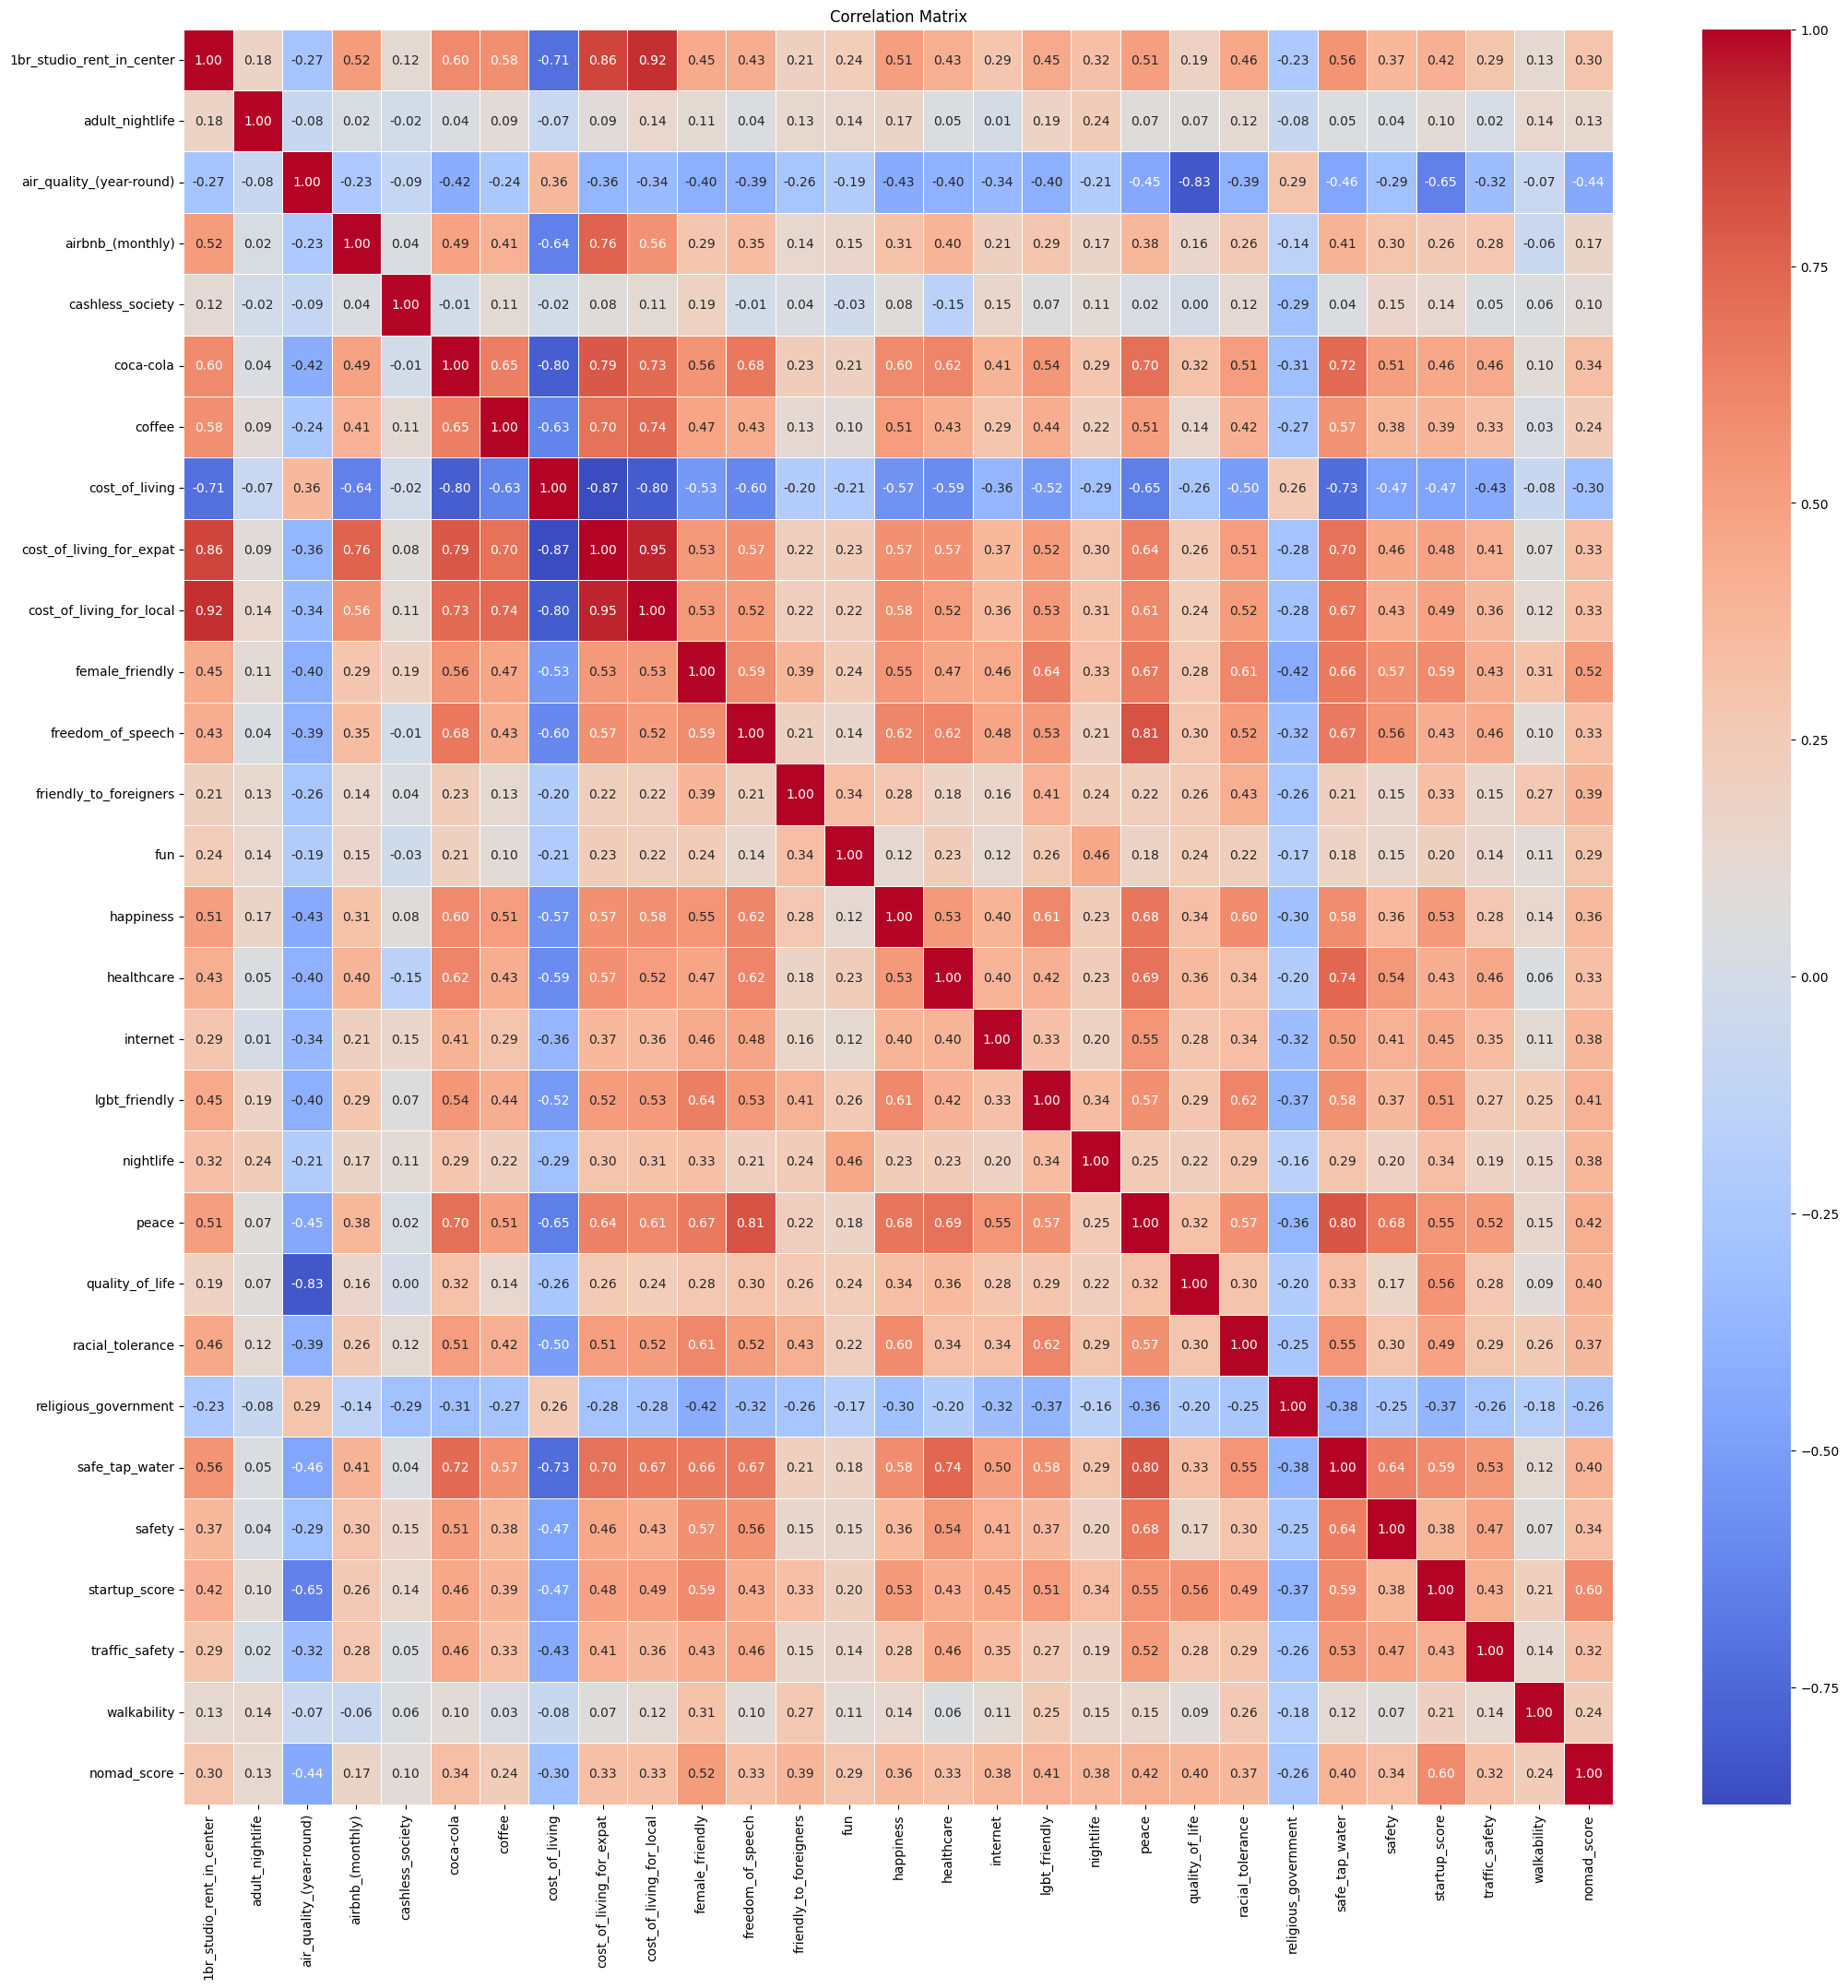

,air_quality_(year-round),cashless_society,cost_of_living,cost_of_living_for_local,female_friendly,freedom_of_speech,friendly_to_foreigners,fun,happiness,healthcare,...,peace,quality_of_life,racial_tolerance,religious_government,safe_tap_water,safety,startup_score,traffic_safety,walkability,nomad_score
0,42.0,1.00000,3.0,-626.0,2.0,1.0,3.0,3.0,3.0,2.0,...,2.0,3.0,1.000000,0.0,0.0,1.0,3.0,4.0,4.0,4.03
1,19.0,1.00000,3.0,-349.0,2.0,1.0,3.0,4.0,3.0,2.0,...,2.0,3.0,1.753777,0.0,0.0,2.0,3.0,4.0,4.0,4.51
2,68.0,1.06622,3.0,-631.0,1.0,1.0,4.0,2.0,2.0,2.0,...,1.0,3.0,2.043748,1.0,0.0,3.0,2.0,1.0,1.0,4.45
3,23.0,2.00000,3.0,-522.0,2.0,1.0,2.0,3.0,1.0,1.0,...,2.0,3.0,2.000000,0.0,0.0,3.0,3.0,3.0,4.0,4.83
4,49.0,3.00000,1.0,-2347.0,2.0,1.0,2.0,4.0,2.0,1.0,...,2.0,3.0,2.000000,0.0,0.0,3.0,4.0,3.0,4.0,4.11


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


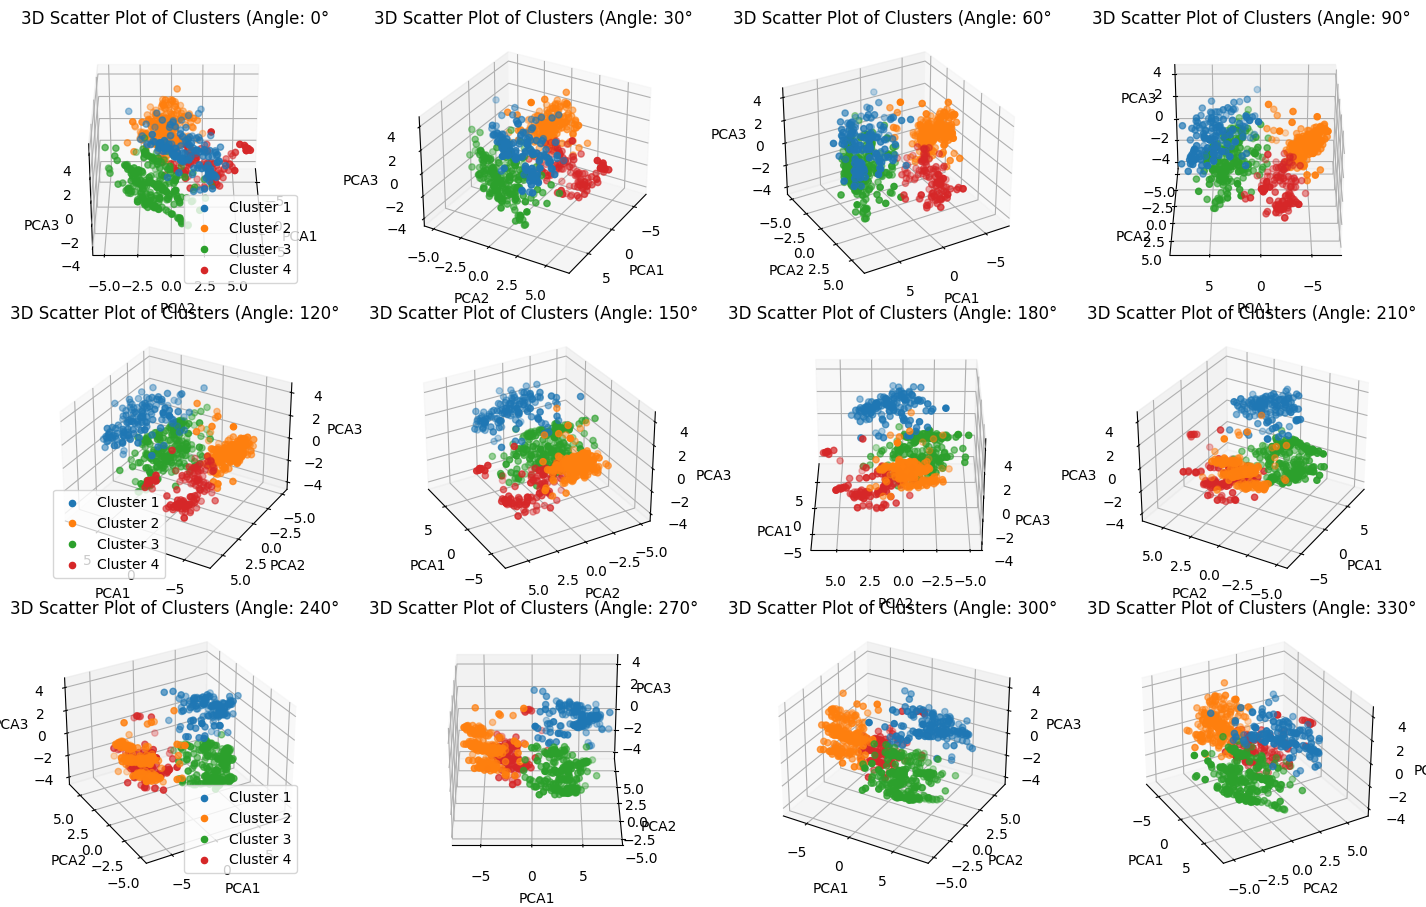

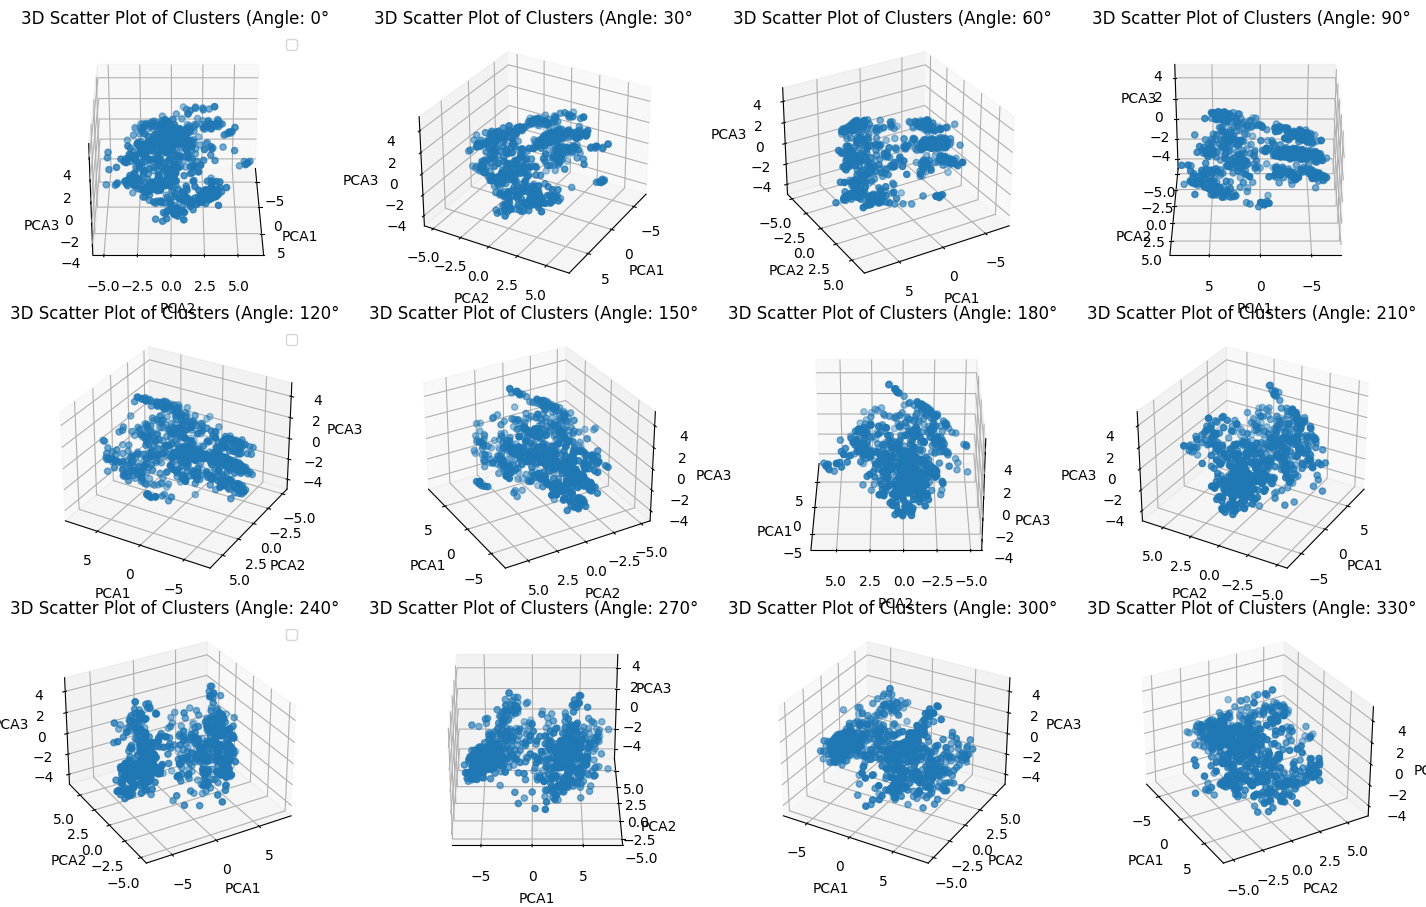

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

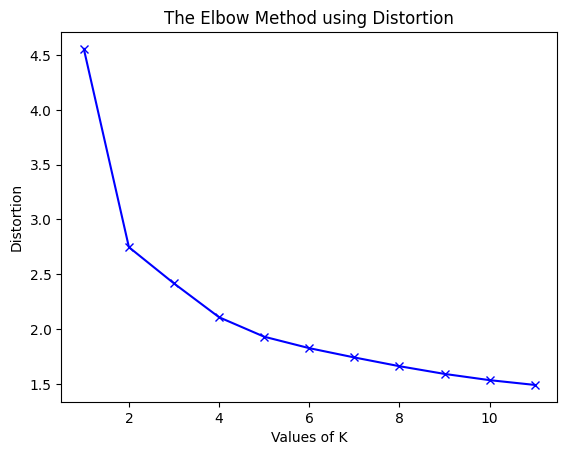

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


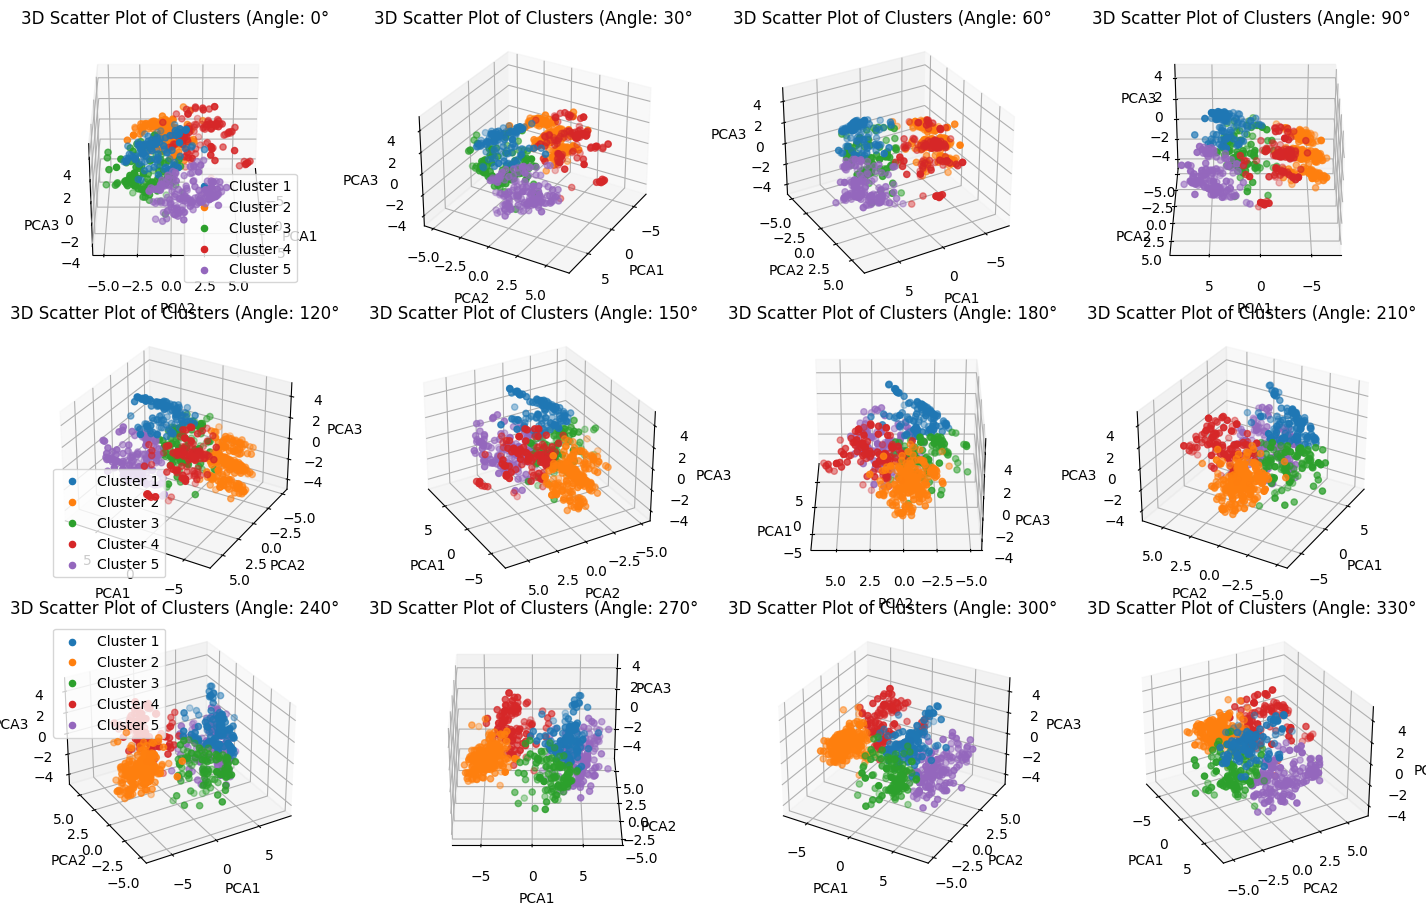

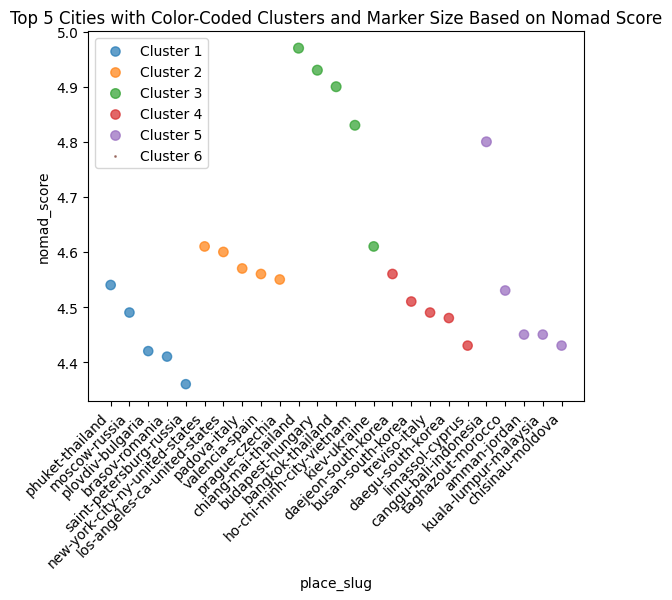

IndexError: ignored

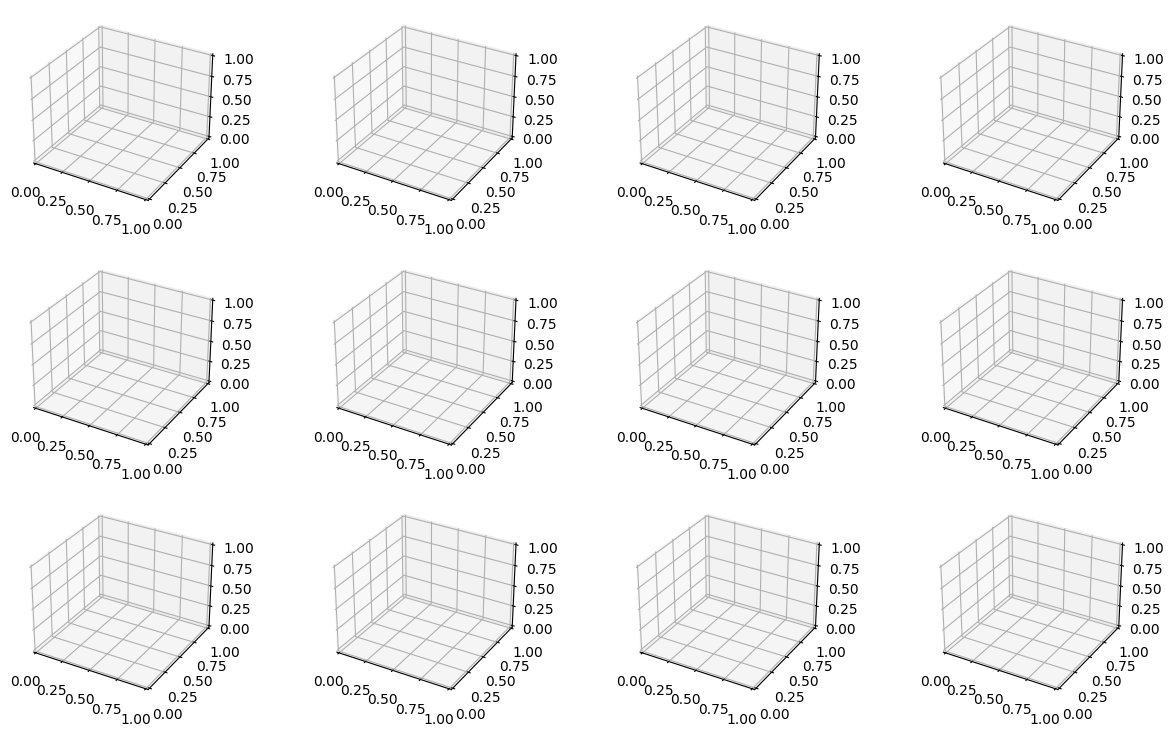

Best Parameters: {'eps': 1.0, 'min_samples': 40}
Best Davies-Bouldin Index: 1.01


Best Parameters: {'n_clusters': 10, 'linkage': 'average', 'metric': 'euclidean'}
Best Davies-Bouldin Index: 0.87


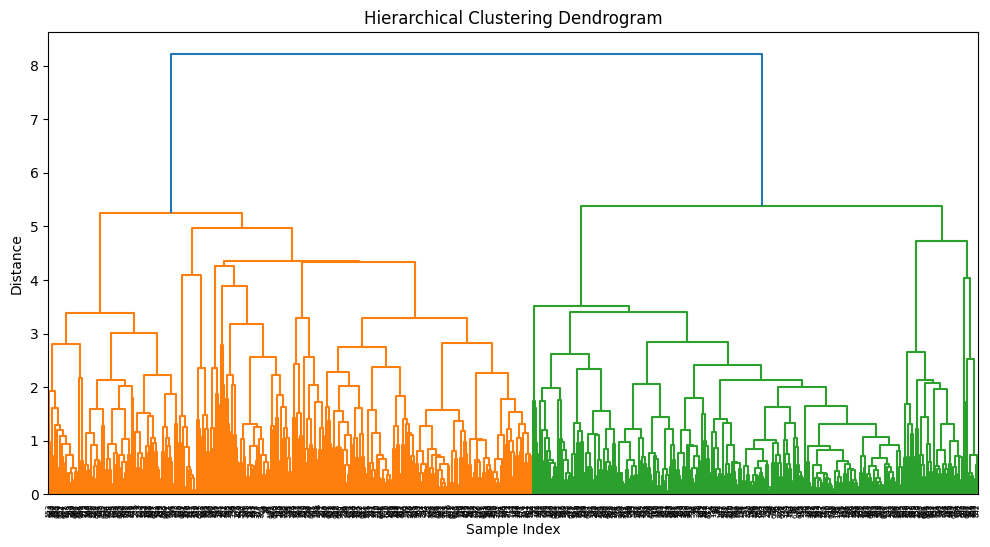

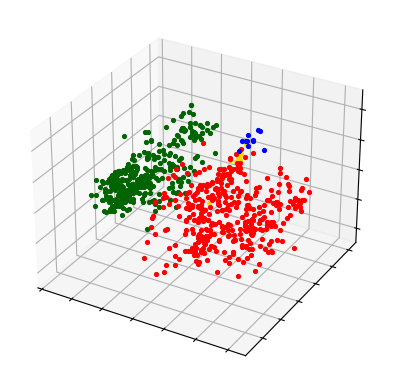

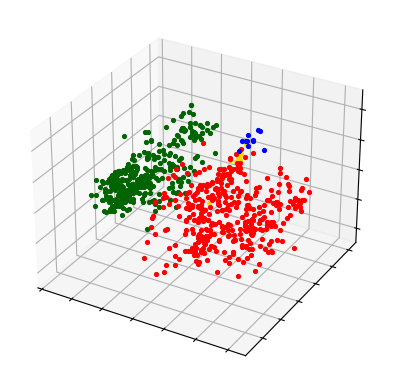

ValueError: ignored